In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append("/users/spate116/singhlab/GCN_Integration/scripts/BI/pyro_model/model")

import torch
from tqdm import tqdm
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch_geometric.data import Data
from torch_geometric.nn import GNNExplainer, GCNConv
import pickle
import networkx as nx
from math import floor
from tqdm.autonotebook import tqdm
import seaborn as sns

import sys
sys.path.append("..")

from model.BayesExplainer import BayesExplainer
from model.samplers.NFSampler import NFSampler
from model.samplers.SpikeSlabSampler import SpikeSlabSampler
from model.samplers.RandomWalkSampler import RandomWalkSampler

from IPython.display import set_matplotlib_formats
%matplotlib inline
set_matplotlib_formats('svg')

G = nx.read_gpickle('data/syn3_G.pickle')
with open('data/syn3_lab.pickle', 'rb') as f:
    labels = pickle.load(f)

x = torch.tensor([x[1]['feat'] for x in G.nodes(data=True)])
edge_index = torch.tensor([x for x in G.edges])
edge_index_flipped = edge_index[:, [1, 0]]
edge_index = torch.cat((edge_index, edge_index_flipped))
y = torch.tensor(labels, dtype=torch.long)
data = Data(x=x, edge_index=edge_index.T, y=y)

class Net(torch.nn.Module):
    def __init__(self, x=64):
        super(Net, self).__init__()
        self.conv1 = GCNConv(10, x)
        self.conv2 = GCNConv(x, x)
        self.conv3 = GCNConv(x, x)
        self.fc = torch.nn.Linear(x, max(y).tolist()+1)

    def forward(self, x, edge_index):
        x = F.leaky_relu(self.conv1(x, edge_index))
        x = F.leaky_relu(self.conv2(x, edge_index))
        x = F.leaky_relu(self.conv3(x, edge_index))
        x = self.fc(x)
        return F.log_softmax(x, dim=1)
    
# Load everything onto the gpu if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
data = data.to(device)
x, edge_index = data.x, data.edge_index

model = Net(x=64).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

best_loss = 100
pbar = tqdm(range(10000))
for epoch in pbar:
    # Training step
    model.train()
    optimizer.zero_grad()
    log_logits = model(x, edge_index)
    loss = F.nll_loss(log_logits, data.y)
    loss.backward()
    optimizer.step()

    # Testing step
    model.eval()
    best_loss = loss if loss < best_loss else best_loss
    pbar.set_description("Acc -> %.4f" % torch.mean((torch.argmax(log_logits, dim=1) == data.y).float()).item())

/gpfs_home/spate116/ml/lib/python3.7/site-packages/ipykernel_launcher.py:29: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
/gpfs_home/spate116/ml/lib/python3.7/site-packages/ipykernel_launcher.py:35: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)


  0%|          | 0/10000 [00:00<?, ?it/s]

Explain node 565: 100%|██████████| 1000/1000 [00:03<00:00, 296.84it/s]


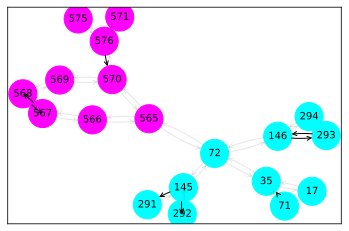

In [2]:
explainer = GNNExplainer(model, epochs=1000)
node_idx = 565
k = 3
node_feat_mask, edge_mask = explainer.explain_node(node_idx, x, edge_index)
ax, G = explainer.visualize_subgraph(node_idx, edge_index, edge_mask, y=data.y)

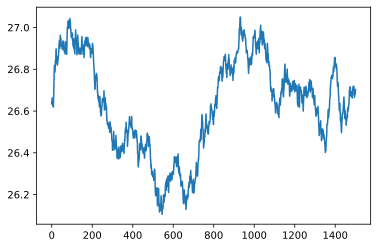

In [ ]:
k = 3
splines = 8
sampler = NFSampler("syn3_nf_sampler", splines, True, 5, 1.5, device)
explainer = BayesExplainer(model, sampler, node_idx, k, x, data.y, edge_index)
avgs = explainer.train(epochs=2000, lr=0.5, window=500, base="..")
sns.lineplot(x = range(len(avgs)), y = avgs)

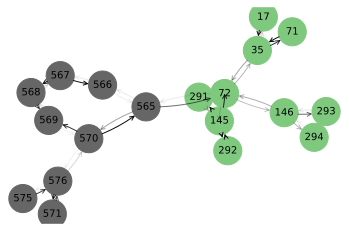

In [ ]:
edge_mask = explainer.edge_mask()
ax, G = explainer.visualize_subgraph()
plt.show()

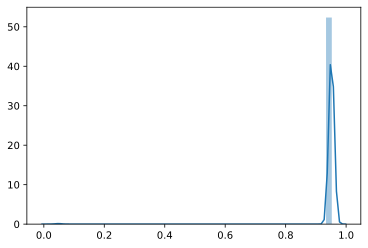

In [ ]:
sns.distplot(explainer.sampler.flow_dist.rsample(torch.Size([10000,])).sigmoid()[:, 7].detach().numpy())

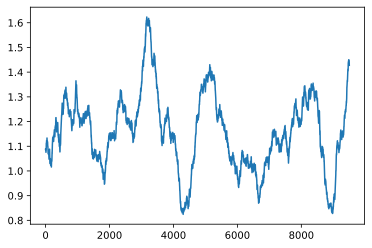

In [ ]:
sampler = SpikeSlabSampler("syn3_spike_slab", 0.25, 1, 5, 10, 1)
explainer = BayesExplainer(model, sampler, node_idx, k, x, data.y, edge_index)
avgs = explainer.train(epochs=10000, lr=0.05, window=500, base="..")
sns.lineplot(x = range(len(avgs)), y = avgs)

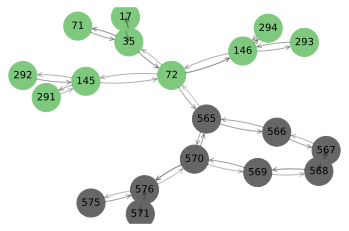

In [ ]:
edge_mask = explainer.edge_mask()
ax, G = explainer.visualize_subgraph()
plt.show()

In [ ]:
edge_mask

tensor([0.3218, 0.4329, 0.4191, 0.2973, 0.4761, 0.3488, 0.3713, 0.2977, 0.3435,
        0.4249, 0.3787, 0.3319, 0.3672, 0.4044, 0.4415, 0.3751, 0.5081, 0.3316,
        0.3844, 0.4262, 0.3796, 0.2801, 0.3194, 0.3191, 0.2233, 0.2765, 0.3783,
        0.3641, 0.3141, 0.3626, 0.4062, 0.2946, 0.4348, 0.2941, 0.2914, 0.2624,
        0.2602, 0.2820], grad_fn=<AddBackward0>)

  0%|          | 0/2500 [00:00<?, ?it/s]

<AxesSubplot:>

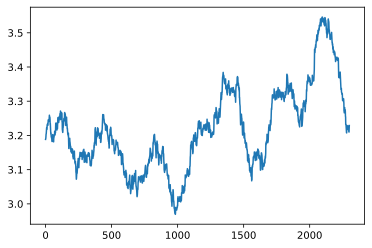

In [15]:
sampler = RandomWalkSampler("syn3_random_walk", 0.25)
explainer = BayesExplainer(model, sampler, node_idx, k, x, data.y, edge_index)
avgs = explainer.train(epochs=2500, lr=0.05, window=200, base="..")
sns.lineplot(x = range(len(avgs)), y = avgs)

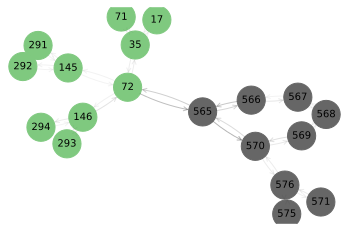

In [16]:
edge_mask = explainer.edge_mask()
ax, G = explainer.visualize_subgraph()
plt.show()

In [17]:
edge_mask

tensor([0.0210, 0.0280, 0.0740, 0.0460, 0.0510, 0.3050, 0.0180, 0.0490, 0.0200,
        0.0610, 0.1640, 0.2770, 0.1000, 0.0330, 0.0330, 0.1470, 0.0870, 0.0700,
        0.0470, 0.0190, 0.0360, 0.0840, 0.0300, 0.1130, 0.1950, 0.0090, 0.0340,
        0.0320, 0.0260, 0.2650, 0.1600, 0.0450, 0.0330, 0.0420, 0.1030, 0.0660,
        0.0510, 0.0120])